In [12]:
import sys

sys.path.append('../../')

import random
import numpy as np
import pylab as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader, RandomSampler
from tqdm import tqdm

from sklearn import datasets
from dal_toolbox.models.deterministic.train import train_one_epoch

In [13]:
X, y = datasets.make_moons(250, noise=.05, random_state=42)
X = (X - X.mean(0)) / X.std(0)
X = torch.from_numpy(X).float()
y = torch.from_numpy(y).long()

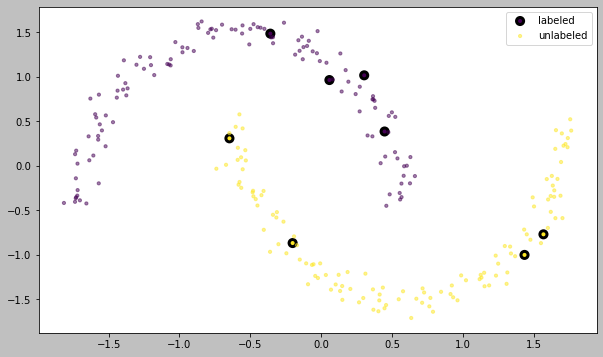

In [14]:
# Setup SSL 
random.seed(1)
indices_class0 = [i for i in range(len(y)) if y[i] == 0]
indices_class1 = [i for i in range(len(y)) if y[i] == 1]
labeled_indices = random.sample(indices_class0, k=4) + random.sample(indices_class1, k=4)
unlabeled_indices = [i for i in range(X.shape[0]) if i not in labeled_indices]

X_labeled, y_labeled = X[labeled_indices], y[labeled_indices]
X_unlabeled, y_unlabeled = X[unlabeled_indices], y[unlabeled_indices]

labeled_ds = torch.utils.data.TensorDataset(X_labeled, y_labeled)
# Using labeled and unlabeled data for unsupervised learning

plt.figure(figsize=(10,6), facecolor='silver')
plt.scatter(X_labeled[:, 0], X_labeled[:, 1], c=y_labeled, s=50, edgecolors='black', linewidths=3, label='labeled')
plt.scatter(X_unlabeled[:, 0], X_unlabeled[:, 1], c=y_unlabeled, s=10, alpha=0.5, label='unlabeled')
plt.legend()
plt.show()

In [15]:
class Net(nn.Module):
    def __init__(self, num_classes: int, dropout_rate: int = 0, feature_dim: int = 128):
        super().__init__()

        self.first = nn.Linear(2, feature_dim)
        self.first_dropout = nn.Dropout(dropout_rate)
        self.hidden = nn.Linear(feature_dim, feature_dim)
        self.hidden_dropout = nn.Dropout(dropout_rate)
        self.last = nn.Linear(feature_dim, num_classes)
        self.act = nn.ReLU()

    def forward(self, x, return_feature=False):
        x = self.act(self.first(x))
        x = self.first_dropout(x)
        x = self.act(self.hidden(x))
        x = self.hidden_dropout(x)
        out = self.last(x)
        if return_feature:
            return out, x
        return out

In [16]:
@torch.no_grad()
def plot_contour(model, X_l, y_l, X_u, y_u, ax=None):
    model.eval()
    model.cpu()
    origin = 'lower'
    if ax:
        plt.sca(ax)
    domain = 3
    xx, yy = torch.meshgrid(torch.linspace(-domain, domain, 51), torch.linspace(-domain, domain, 51), indexing='ij')
    zz = torch.stack((xx.flatten(), yy.flatten()), dim=1)

    logits = model(zz)
    probas = logits.softmax(-1)
    zz = probas[:, 1].view(xx.shape)

    plt.scatter(X_l[:, 0], X_l[:, 1], c=y_l, s=50, edgecolors='red')
    plt.scatter(X_u[:, 0], X_u[:, 1], c=y_u, s=1)
    CS = plt.contourf(xx, yy, zz, alpha=.8, zorder=-1, levels=np.linspace(0, 1, 6), origin=origin)
    CS2 = plt.contour(CS, levels=[0.5], colors='black', origin=origin)
    cbar = plt.colorbar(CS)
    cbar.add_lines(CS2)

## Fully-Supervised-Model

Epoch [0] [0/1] eta: 0:00:00 lr: 0.01 loss: 0.6937 (0.6937) acc1: 50.0000 (50.0000) time: 0.0013 data: 0.0002 max mem: 0
Epoch [0] Total time: 0:00:00
Epoch [1] [0/1] eta: 0:00:00 lr: 0.01 loss: 0.6842 (0.6842) acc1: 50.0000 (50.0000) time: 0.0011 data: 0.0001 max mem: 0
Epoch [1] Total time: 0:00:00
Epoch [2] [0/1] eta: 0:00:00 lr: 0.01 loss: 0.6670 (0.6670) acc1: 50.0000 (50.0000) time: 0.0012 data: 0.0002 max mem: 0
Epoch [2] Total time: 0:00:00
Epoch [3] [0/1] eta: 0:00:00 lr: 0.01 loss: 0.6440 (0.6440) acc1: 50.0000 (50.0000) time: 0.0011 data: 0.0001 max mem: 0
Epoch [3] Total time: 0:00:00
Epoch [4] [0/1] eta: 0:00:00 lr: 0.01 loss: 0.6165 (0.6165) acc1: 75.0000 (75.0000) time: 0.0010 data: 0.0002 max mem: 0
Epoch [4] Total time: 0:00:00
Epoch [5] [0/1] eta: 0:00:00 lr: 0.01 loss: 0.5863 (0.5863) acc1: 87.5000 (87.5000) time: 0.0009 data: 0.0001 max mem: 0
Epoch [5] Total time: 0:00:00
Epoch [6] [0/1] eta: 0:00:00 lr: 0.01 loss: 0.5549 (0.5549) acc1: 87.5000 (87.5000) time: 0.00

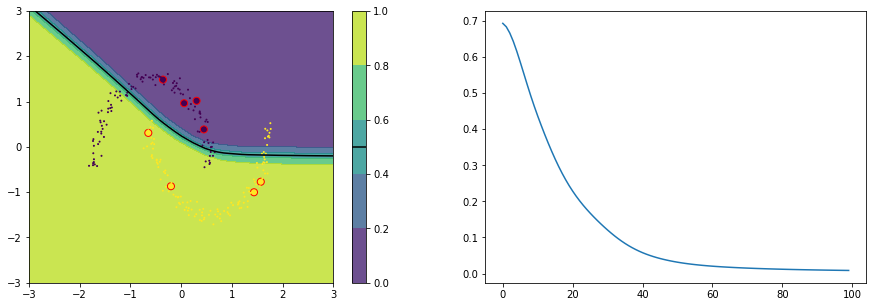

In [17]:
torch.manual_seed(0)

n_epochs = 100 # number of epochs for training
batch_size = 32 # batch_size of labeled samples per iteration

labeled_loader = DataLoader(labeled_ds, batch_size=batch_size, shuffle=True)

fs_optimizer_params = dict(lr=0.01, weight_decay=0.0001, momentum=.9,)
fs_model = Net(dropout_rate=0, num_classes=2)
fs_optimizer = torch.optim.SGD(fs_model.parameters(), **fs_optimizer_params)
criterion = torch.nn.CrossEntropyLoss()

history = []
for i in range(n_epochs):
    train_stats = train_one_epoch(
        model=fs_model, dataloader=labeled_loader, criterion=criterion, 
        optimizer=fs_optimizer, device='cuda', epoch=i)
    history.append(train_stats)

fs_model.eval()
plt.figure(figsize=(15, 5))
plt.subplot(121)
plot_contour(fs_model, X_labeled, y_labeled, X_unlabeled, y_unlabeled)
plt.subplot(122)
plt.plot([d['train_loss'] for d in history])
plt.show()